# FGSM with PyTorch

In [38]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import json
import matplotlib.pyplot as plt

In [49]:
model = models.resnet101(pretrained=True)
model.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [50]:
CLASSES = json.load(open('./imagenet_samples/imagenet_classes.json'))
idx2class = [CLASSES[str(i)] for i in range(1000)]

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([[0.1216, 0.1059, 0.0824, 0.0471, 0.1608],
        [0.1725, 0.1882, 0.0980, 0.0431, 0.2000],
        [0.2039, 0.1647, 0.1176, 0.0549, 0.1412],
        [0.1294, 0.1137, 0.1529, 0.0941, 0.1059],
        [0.1059, 0.1020, 0.1922, 0.1333, 0.0549]])


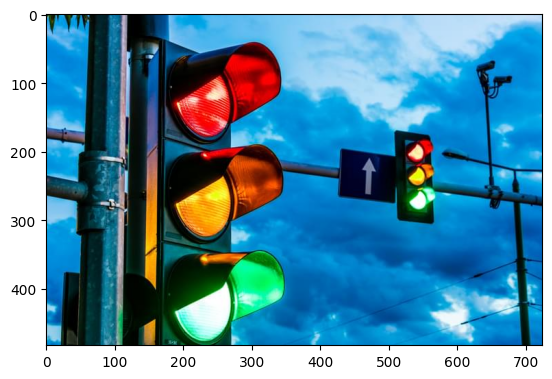

In [51]:
img = Image.open('./imagenet_samples/stoplight.jpg')
img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor()
])

img_tensor = img_transforms(img)
print(img_tensor.shape)
img_tensor = img_tensor.unsqueeze(0)
print(img_tensor.shape)
print(img_tensor[0,0,:5,:5])

plt.imshow(img)
plt.show()

In [52]:
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호:", prediction_idx)
print("레이블 이름:", prediction_name)

예측된 레이블 번호: 920
레이블 이름: traffic light, traffic signal, stoplight


In [53]:
def fgsm(image, epsilon, gradient):
  sign_gradient = gradient.sign()
  adversarial_example = image + epsilon * sign_gradient
  adversarial_example = torch.clamp(adversarial_example, 0, 1)

  return adversarial_example

In [64]:
img_tensor.requires_grad_(True)

output = model(img_tensor)

loss = F.nll_loss(output, torch.tensor([920])) # label 920 is stoplight(traffic sign)

model.zero_grad()
loss.backward() # save the gradient of input image on grad.data

gradient = img_tensor.grad.data

epsilon = 0.01
adversarial_example = fgsm(img_tensor, epsilon, gradient)

output = model(adversarial_example)

In [65]:
print(img_tensor[0,0,:5,:5])

tensor([[0.1216, 0.1059, 0.0824, 0.0471, 0.1608],
        [0.1725, 0.1882, 0.0980, 0.0431, 0.2000],
        [0.2039, 0.1647, 0.1176, 0.0549, 0.1412],
        [0.1294, 0.1137, 0.1529, 0.0941, 0.1059],
        [0.1059, 0.1020, 0.1922, 0.1333, 0.0549]], grad_fn=<SliceBackward0>)


In [66]:
print(adversarial_example[0,0,:5,:5])

tensor([[0.1116, 0.0959, 0.0924, 0.0571, 0.1508],
        [0.1625, 0.1982, 0.0880, 0.0331, 0.1900],
        [0.1939, 0.1547, 0.1076, 0.0449, 0.1312],
        [0.1394, 0.1037, 0.1429, 0.1041, 0.1159],
        [0.1159, 0.0920, 0.2022, 0.1433, 0.0649]], grad_fn=<SliceBackward0>)


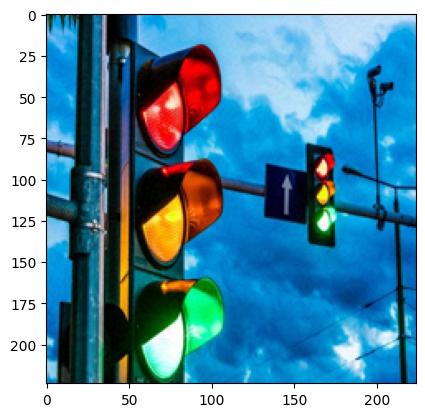

In [67]:
adversarial_example_view = adversarial_example.squeeze(0).detach()
adversarial_example_view = adversarial_example_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(adversarial_example_view)

In [68]:
adversarial_example = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = adversarial_example.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호:", perturbed_prediction_idx)
print("레이블 이름:", perturbed_prediction_name)

예측된 레이블 번호: 837
레이블 이름: sunglasses, dark glasses, shades
